# Alternating Direction Method of Multipliers (ADMM) and splitting  across examples (Consensus Algorithm)

In [1]:
#importing libraries
import numpy as np
from numpy.linalg import inv,norm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder,LabelBinarizer,MinMaxScaler
import time
import scipy
from tqdm import tqdm_notebook
from multiprocessing import cpu_count

# Tic-Tac-Toe

The target concept is “win for x” (i.e., true when “x” has one of 8 possible ways to create a “three-in a-row”).


![](https://stickershop.line-scdn.net/stickershop/v1/product/4180220/LINEStorePC/main.png;compress=true)

* (x=player x has taken, o=player o has taken, b=blank)

<br>

*you can download and see more about the dataset [here](https://datahub.io/machine-learning/tic-tac-toe).*
<br>

In [2]:
#import data
df = pd.read_csv('tic-tac-toe.csv')
df.head(10)

,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square,Class
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive
5,x,x,x,x,o,o,b,b,o,positive
6,x,x,x,x,o,b,o,o,b,positive
7,x,x,x,x,o,b,o,b,o,positive
8,x,x,x,x,o,b,b,o,o,positive
9,x,x,x,x,b,o,o,o,b,positive


### Dataset Description

In [3]:
df.describe()

,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square,Class
count,958,958,958,958,958,958,958,958,958,958
unique,3,3,3,3,3,3,3,3,3,2
top,x,x,x,x,x,x,x,x,x,positive
freq,418,378,418,378,458,378,418,378,418,626


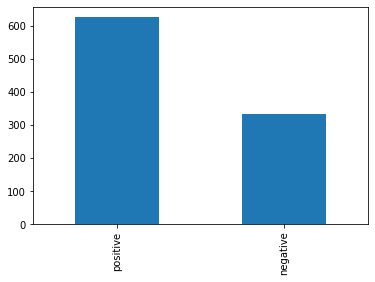

In [4]:
df['Class'].value_counts().plot(kind='bar')

In [5]:
#binarize target
label = LabelEncoder() 
label.fit(list(df['Class'].values)) 
b = label.transform(list(df['Class'].values))

In [6]:
#one_hot_encoding of inputs with create dummies
df.drop('Class',axis=1,inplace=True)
df = pd.get_dummies(df)
df.head()

,top-left-square_b,top-left-square_o,top-left-square_x,top-middle-square_b,top-middle-square_o,top-middle-square_x,top-right-square_b,top-right-square_o,top-right-square_x,middle-left-square_b,...,middle-right-square_x,bottom-left-square_b,bottom-left-square_o,bottom-left-square_x,bottom-middle-square_b,bottom-middle-square_o,bottom-middle-square_x,bottom-right-square_b,bottom-right-square_o,bottom-right-square_x
0,0,0,1,0,0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,1,0
1,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,1,0,1,0
2,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1
3,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,1,0,0,1,0,0
4,0,0,1,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0


In [7]:
A = df.values

In [8]:
#train_test split
A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.33, random_state=42)

## Sparce Logistic Regression (ADMM)

<br>

$minimize \; (1/2)||\sigma(A x) - b||_2^{2} + \lambda ||x||_1$

where $\sigma$ is the sigmoid fuction:

$\sigma(z) = \frac{exp(z)}{1+exp(z)} = \frac{1}{1+exp(-z)}$

<br>

**Centralized Case**:


<br>

$x^{k+1} = argmin  (l||A x - b||_2^{2} +(\rho/2)||x - z^k + u^{k}||_2^{2} )$

$z^{k+1} = S_{λ/ρ}(x^{k+1} + u^k)$

$u^{k+1} = u^{k} + x^{k+1} - z^{k+1}$

<br>

where $l$ is the *logistic regression* cost fuction or more known as *cross-entropy*:

$ l = (-1/N)\sum{b \log(\sigma(A x)) + (1-b) \log(1 - \sigma(A x))}$

or in a more compact form:

$ l = (1/N) \sum{\log(1+exp(-b x^{T}A))} $



<br>


**Consensus ( not scaled) form of the model**:

<br>

$ minimize \sum{l_i(A_i x_i - b_i) + r(z)}$, subject to $x_i − z = 0, i = 1, . . . , N$
 
where $l_i$ refers to the loss function for the ith block of
data.

<br>

Consensus ADMM algorithm for Sparse Logistic Regression problem:

$x_i^{k+1} = argmin  ( ||l_i(A_i x_i) - b_i||_2^{2} +(\rho/2)||x_i - z^k + u_i^{k}||_2^{2} )$

$z^{k+1} = S_{λ/ρN}(\overline{x}^{k+1} + \overline{u}^k)$

$u_i^{k+1} = u_i^{k} + x_i^{k+1} - z^{k+1}$

<br>

This is identical to distributed lasso, except for $x_i$ update, which here involves an $l_2$ regularized
logistic regression problem.

<br>

*Of course we can see that for N=1 the parallel and centralized cases coincide.*



In [9]:
class ADMM_Sparse_Logistic_Regression:
    
    def __init__(self, A, b,rho=1,alpha=0.001,parallel = False):
        self.N = A.shape[0]
        self.D = A.shape[1]
        self.A = A
        self.b = b
        self.parallel = parallel
        if self.parallel:
            self.numberOfThreads = cpu_count()  ###default=4
            self.X = np.random.randn(self.numberOfThreads, self.D)
            self.X_bar = self.X.mean(axis=0)
            self.nu = np.zeros((self.numberOfThreads, self.D))
            self.nu_bar = self.nu.mean(axis=0)
            ind = np.arange(self.N)
            np.random.shuffle(ind)
            self.ind = np.array_split(ind,self.numberOfThreads)
        else:
            self.numberOfThreads = 1
            self.X = np.random.randn(self.D)
            self.nu = np.zeros(self.D)
        self.rho = rho
        self.Z = np.zeros(self.D)
        self.alpha = alpha
        self.threshold = self.alpha/(self.rho*self.numberOfThreads)
        
        
    def soft_thresholding(self, x):
         
        t = self.threshold
        y = np.zeros(x.shape)

        y[x >= t] = x[x >= t] - t
        y[x <= t] = x[x <= t] + t

        return(y)
    
    def sigmoid(self,X):
        return(1/(1+np.exp(-X)))
    
    def cross_entropy(self,X,A,b):
        h = self.sigmoid(A.dot(X))
        return (1/self.N)*np.sum((((-b).T.dot(np.log(h)))-((1-b).T.dot(np.log(1-h)))))
    
    
    def X_objective(self,X,*args):
        A = args[0]
        b = args[1]
        rho = args[2]
        Z = args[3]
        nu = args[4]
        #return((1/self.N)*np.sum(np.log(1+np.exp(-b*A.dot(X)))) + (rho/2.0) * np.sum((X-Z+nu)**2))  ##2ND FORM
        return(self.cross_entropy(X,A,b) + (rho/2.0) * np.sum((X-Z+nu)**2))
    
    def get_objective(self):
        if self.parallel:
            X = self.X_bar
            nu = self.nu_bar
        else:         
            X = self.X
            nu = self.nu
        Z = self.Z
        rho = self.rho
        A = self.A
        b = self.b
        return(0.5 * norm(self.sigmoid(self.A.dot(X)) - self.b,2)**2 + self.alpha *  norm(X, 1))
    
    def step(self):
        #start_time = time.time()
        # Solve for X_t+1
        self.X = scipy.optimize.minimize(self.X_objective,self.X,args=(self.A,self.b,self.rho,self.Z,self.nu),method='L-BFGS-B').x
        # Solve for Z_t+1
        self.Z = self.soft_thresholding(self.X + self.nu)
        # Combine in u_t+1
        self.nu += (self.X - self.Z)
        #elapsed_time = time.time() - start_time
        #print(elapsed_time)
        
    
    def step_parallel(self):
        #t = []
        for n,k in enumerate(self.ind):
            #start_time = time.time()
            # Solve for X{i}_t+1
            self.X[n] = scipy.optimize.minimize(self.X_objective,self.X[n],args=(self.A[k],self.b[k],self.rho,self.Z,self.nu[n]),method='L-BFGS-B').x   
            self.X_bar = self.X.mean(axis=0)
            # Solve for Z_t+1
            self.Z = self.soft_thresholding(self.X_bar + self.nu_bar)
            # Combine in u{i}_t+1
            self.nu[n] += (self.X[n] - self.Z)
            self.nu_bar = self.nu.mean(axis=0)
            #elapsed_time = time.time() - start_time
            #t.append(elapsed_time)

    def next_step(self):
        if self.parallel:
            self.step_parallel()
        else:
            self.step()
            
        
    def get_weights(self):
        if self.parallel:
            return(self.X_bar)
        else:
            return(self.X)

In [10]:
#number of reps
reps = 5000

## Centralized_Case

In [11]:
obj_centralized = []
acc_centralized = []
model_centralized = ADMM_Sparse_Logistic_Regression(A_train,b_train,parallel=False)
obj_centralized.append(model_centralized.get_objective())
for k in tqdm_notebook(range(reps)):
    model_centralized.next_step()
    w = model_centralized.get_weights()
    y_pred = np.round(model_centralized.sigmoid(A_test.dot(w)))
    acc_centralized.append(accuracy_score(b_test, y_pred))
    obj_centralized.append(model_centralized.get_objective())

In [12]:
print(w)
y_pred = np.round(model_centralized.sigmoid(A_test.dot(w)))
print('Accuracy: {}'.format(accuracy_score(b_test, y_pred)))

[ 0.05402935 -6.08337926  5.24639077  0.10144788 -5.90215367  5.01974688
  0.06364417 -6.09409056  5.24548713  0.19360942 -5.96424968  5.00968073
  0.12296767 -6.39691804  5.49099104  0.06040978 -5.82373628  4.96236754
  0.05241829 -6.06573673  5.36234188  0.05476383 -5.75062713  5.00088409
  0.0743756  -6.2540316   5.39669727]
Accuracy: 0.9810725552050473


## Parallel_Case

In [13]:
obj_parallel = []
acc_parallel = []
model_parallel = ADMM_Sparse_Logistic_Regression(A_train,b_train,parallel=True)
obj_parallel.append(model_parallel.get_objective())
for k in tqdm_notebook(range(reps)):
    model_parallel.next_step()
    w = model_parallel.get_weights()
    y_pred = np.round(model_parallel.sigmoid(A_test.dot(w)))
    acc_parallel.append(accuracy_score(b_test, y_pred))
    obj_parallel.append(model_parallel.get_objective())

In [14]:
print(w)
y_pred = np.round(model_parallel.sigmoid(A_test.dot(w)))
print('Accuracy: {}'.format(accuracy_score(b_test, y_pred)))

[ 0.00635971 -5.24230989  4.52825385  0.0765958  -4.97996528  4.26715707
  0.07617413 -5.18466907  4.55724741  0.03842821 -5.18932847  4.12631294
  0.03384847 -5.63367912  4.73163227  0.00947289 -4.94991443  4.22064329
  0.01214544 -5.18560937  4.64045265  0.01256353 -4.85282872  4.26504038
  0.25357783 -5.14064362  4.85592694]
Accuracy: 0.9810725552050473


### SkLearn Model

In [15]:
model_sklearn = LogisticRegression(penalty='l1')
model_sklearn.fit(A_train,b_train)
y_pred = model_sklearn.predict(A_test)
acc_sklearn = accuracy_score(b_test, y_pred)
print(model_sklearn.coef_)
print(model_sklearn.intercept_)
print('Accuracy: {}'.format(acc_sklearn))

[[ 1.69819135e-06 -5.27551754e+00  4.64029669e+00  3.75562239e-02
  -5.06994407e+00  4.35878240e+00  0.00000000e+00 -5.28878835e+00
   4.60442610e+00  0.00000000e+00 -5.27021121e+00  4.21736610e+00
   0.00000000e+00 -5.67698980e+00  4.83038994e+00  2.52824295e-05
  -5.00465638e+00  4.32994028e+00  0.00000000e+00 -5.23718895e+00
   4.75696399e+00  0.00000000e+00 -4.90899070e+00  4.36342880e+00
   0.00000000e+00 -5.43193570e+00  4.73359997e+00]]
[0.10647183]
Accuracy: 0.9810725552050473


/home/jason/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Compare Results

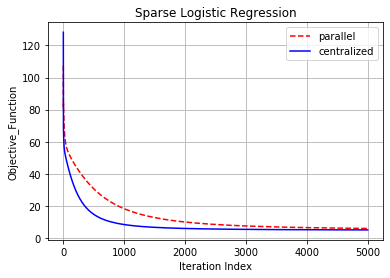

In [16]:
t = np.arange(reps+1)
plt.plot(t,obj_parallel,linestyle='--',color='r',label='parallel')
plt.plot(t,obj_centralized,'b',label='centralized')
plt.grid()
plt.title('Sparse Logistic Regression')
plt.xlabel('Iteration Index')
plt.ylabel('Objective_Function')
plt.legend()
plt.show()

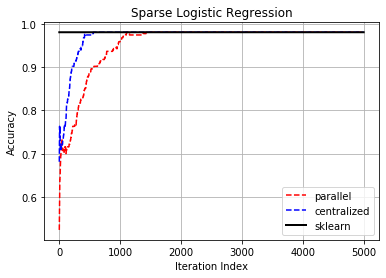

In [17]:
t = np.arange(reps)
plt.plot(t,acc_parallel,linestyle='--',color='r',label='parallel')
plt.plot(t,acc_centralized,linestyle='--',color='b',label='centralized')
plt.plot(t,np.ones(reps)*acc_sklearn,color='black',linewidth=2,label='sklearn')
plt.grid()
plt.title('Sparse Logistic Regression')
plt.xlabel('Iteration Index')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### <ins>References</ins>

* Slides for Signal Processing for Big Data - Distributed Optimization and Statistical Learning (Sergio Barbarossa and Paolo Di Lorenzo)
* Distributed convex optimization using ADMM (Dimitris Christodouleas)
* Distributed Optimization and Statistical Learning via the Alternating Direction Method of Multipliers (R Foundations and Trends in Machine Learning Vol. 3, No. 1 (2010) 1–122 c 2011 S. Boyd, N. Parikh, E. Chu, B. Peleato and J. Eckstein DOI: 10.1561/2200000016
* Alternating Direction Method of Multipliers for Distributed Machine Learning (Sourangshu Bhattacharya)